In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import zhinst.toolkit as tk

In [2]:
mdc = tk.MultiDeviceConnection()
mdc.setup()

Successfully connected to data server at localhost8004 api version: 6


In [3]:
hd = tk.HDAWG("hd", "dev8030", interface="1GbE")
qa = tk.UHFQA("qa", "dev2266", interface="1GbE")

In [4]:
mdc.connect_device(hd)
mdc.connect_device(qa)

Successfully connected to device DEV8030 on interface 1GBE
Successfully connected to device DEV2266 on interface 1GBE


# Qubit Spectroscopy

Use HDAWG awg 1 to send qubit drive pulse and trigger UHFQA Readout.

In [21]:
averages = 2**10
period = 20e-6

pulse_time = 2e-6
pulse_samples = int(pulse_time * 2.4e9)
drive_freqs = np.linspace(50e6, 70e6, 100)

int_time = 2e-6

In [22]:
# prepare sequence on HDAWG

hd.awgs[0].set_sequence_params(
    sequence_type="Simple",
    repetitions=averages,
    period=period,
    alignment="End with Trigger",
    trigger_mode="Send Trigger",
)
wave = np.ones(4800)
hd.awgs[0].reset_queue()
hd.awgs[0].queue_waveform(wave, wave)
hd.awgs[0].compile_and_upload_waveforms()

Current length of queue: 1
Compilation successful
hd-0: Sequencer status: ELF file uploaded
Upload of 1 waveforms took 0.02592 s


In [23]:
# enable IQ modulation of HDAWG
hd.awgs[0].enable_iq_modulation()
hd.awgs[0].modulation_freq(60e6)

60000000.0

In [24]:
# prepare readout channel on UHFQA
qa.integration_time(int_time)
qa.channels[0].enable()
qa.channels[0].readout_frequency(87.3e6)

In [25]:
qa.channels

[Readout Channel 0:  <zhinst.toolkit.uhfqa.ReadoutChannel object at 0x00000273505EBCF8>
      rotation          : 180.0
      threshold         : 0.0
      readout_frequency : 87300000.0
      readout_amplitude : 1
      phase_shift       : 0,
 Readout Channel 1:  <zhinst.toolkit.uhfqa.ReadoutChannel object at 0x00000273505EBDD8>
      rotation          : 0.0
      threshold         : 0.0
       Weighted Integration Disabled,
 Readout Channel 2:  <zhinst.toolkit.uhfqa.ReadoutChannel object at 0x00000273505EBEB8>
      rotation          : 0.0
      threshold         : 0.0
       Weighted Integration Disabled,
 Readout Channel 3:  <zhinst.toolkit.uhfqa.ReadoutChannel object at 0x00000273505EBF98>
      rotation          : 0.0
      threshold         : 0.0
       Weighted Integration Disabled,
 Readout Channel 4:  <zhinst.toolkit.uhfqa.ReadoutChannel object at 0x00000273505EF0B8>
      rotation          : 0.0
      threshold         : 0.0
       Weighted Integration Disabled,
 Readout Cha

In [26]:
qa.awg.set_sequence_params(
    sequence_type="Readout",
    repetitions=averages,
    period=period,
    alignment="Start with Trigger",
    trigger_mode="External Trigger",
    readout_length=int_time,
    trigger_delay=-30e-9,
)
qa.awg.compile()

Compilation successful
qa-0: Sequencer status: ELF file uploaded


In [28]:
hd.awgs[0].output1("off")
qa.awg.outputs("on")

In [29]:
# configure result acquisition
# use hardware avergages

qa.result_source("integration")
qa.nodetree.qa.result.length(len(drive_freqs))
qa.nodetree.qa.result.averages(averages)
qa.nodetree.qa.result.enable(1)
qa.nodetree.qa.result.reset(0)
qa.nodetree.qa.result.reset(1)

1

In [30]:
# acquire data only at the end of the measurement
tik = time.time()

for f in drive_freqs:
    hd.awgs[0].modulation_freq(f)
    qa.awg.run()
    time.sleep(0.05)
    hd.awgs[0].run()
    qa.awg.wait_done()
res = qa.channels[0].result()

print(time.time() - tik)

Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AWG hd-0!
Started AWG qa-0!
Started AW

In [31]:
# # configure result acquisition
# # acquire data per shot and append average of `length` to result vector

# qa.result_source("integration")
# qa.nodetree.qa.result.length(averages)
# qa.nodetree.qa.result.averages(1)
# qa.nodetree.qa.result.enable(1)
# qa.nodetree.qa.result.reset(0)
# qa.nodetree.qa.result.reset(1)

# tik = time.time()

# res = np.array([])
# for f in drive_freqs:
#     qa.nodetree.qa.result.reset(0)
#     qa.nodetree.qa.result.reset(1)
#     hd.awgs[0].modulation_freq(f)
#     qa.awg.run()
#     time.sleep(0.05)
#     hd.awgs[0].run()
#     qa.awg.wait_done()
#     res = np.append(res, np.mean(qa.channels[0].result()))

# print(time.time() - tik)

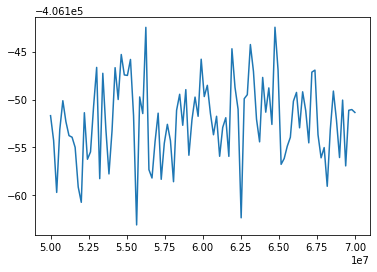

In [32]:
plt.plot(drive_freqs, np.real(res))
plt.show()

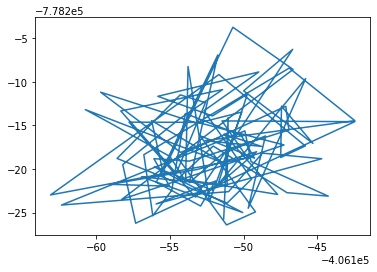

In [33]:
plt.plot(np.real(res), np.imag(res))
plt.show()